**In this notebook we process data for analysis into the necessary file types and filter for cells**

In [4]:
import h5py
import scanpy as sc
import anndata
import loompy as lp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## **Benchmarking Datasets**

### **Allen Institute Brain Data**

Single-cell and single-nucleus data from BICCN MOP data

Need to process fastqs for single-nuc data from multiple samples (sequenced together)

In [17]:
#Raw single-cell A08 10xv3 brain sample from https://zenodo.org/records/10530877

a08 = lp.connect('/home/tchari/counts/allen_bivi/loom/allen_A08_raw.loom')
bars = a08.ca['barcode']
print(bars[0])
genes = a08.ra['gene_name']
U = a08.layers['unspliced'][:,:]
S = a08.layers['spliced'][:,:]
print(S.shape)

AAACCCAAGAGGCTGT
(32285, 9974)


In [18]:
a08.close()

In [10]:
meta_a08 = pd.read_csv('/home/tchari/metadata/allen_sc_sample_metadata.csv')
meta_a08.head()

,Unnamed: 0,aggr_num,umi.counts,gene.counts,library_id,tube_barcode,Seq_batch,Region,Lib_type,Gender,...,Live_percent,Total_Cells,Live_Cells,method,exp_component_name,mapped_reads,unmapped_reads,nonconf_mapped_reads,total.reads,doublet.score
0,AAACCCAAGCTTCATG-1L8TX_181211_01_G12,1,55812,7122,L8TX_181211_01_G12,SM-HH8FP-1,RTX-841,MOp,Cells_FACS-tdT,Male,...,75%,7882,5898,10xv3,AAACCCAAGCTTCATG-1L8TX_181211_01_G12,141238,2460,11355,155053.0,0.154639
1,AAACCCAAGGCGCTTC-1L8TX_181211_01_G12,1,1670,668,L8TX_181211_01_G12,SM-HH8FP-1,RTX-841,MOp,Cells_FACS-tdT,Male,...,75%,7882,5898,10xv3,AAACCCAAGGCGCTTC-1L8TX_181211_01_G12,4160,64,1049,5273.0,0.030928
2,AAACCCAAGGCTTAAA-1L8TX_181211_01_G12,1,1873,406,L8TX_181211_01_G12,SM-HH8FP-1,RTX-841,MOp,Cells_FACS-tdT,Male,...,75%,7882,5898,10xv3,AAACCCAAGGCTTAAA-1L8TX_181211_01_G12,6404,47,2539,8990.0,0.000000
3,AAACCCAAGTGAGGTC-1L8TX_181211_01_G12,1,36622,6125,L8TX_181211_01_G12,SM-HH8FP-1,RTX-841,MOp,Cells_FACS-tdT,Male,...,75%,7882,5898,10xv3,AAACCCAAGTGAGGTC-1L8TX_181211_01_G12,90968,1351,7997,100316.0,0.163265
4,AAACCCACACCAGCCA-1L8TX_181211_01_G12,1,90475,8322,L8TX_181211_01_G12,SM-HH8FP-1,RTX-841,MOp,Cells_FACS-tdT,Male,...,75%,7882,5898,10xv3,AAACCCACACCAGCCA-1L8TX_181211_01_G12,240181,4107,20590,264878.0,0.164948


In [34]:
a08_members = pd.read_csv('/home/tchari/metadata/allen_sc_cluster.membership.csv')
a08_annots =  pd.read_csv('/home/tchari/metadata/allen_sc_cluster.annotation.csv')
a08_annots.head()

,cluster_id,cluster_label,subclass_label,class_label,cluster_color,size
0,1,Lamp5 Pax6,Lamp5,GABAergic,#DDACC9,81
1,2,Lamp5 Egln3_2_1,Lamp5,GABAergic,#DD8091,179
2,3,Lamp5 Pdlim5_1,Lamp5,GABAergic,#FF829E,247
3,4,Lamp5 Pdlim5_2,Lamp5,GABAergic,#FF7290,537
4,5,Lamp5 Slc35d3_1,Lamp5,GABAergic,#FFA388,1275


In [85]:
sub_meta = meta_a08[meta_a08.library_id.isin(['L8TX_190430_01_A08'])]
sublab = []
classlab = []
bars_filt = []
for b in list(sub_meta['Unnamed: 0']):
    ind = a08_members['Unnamed: 0'] == b
    if np.sum(ind) >0:
        lab = list(a08_members['x'][ind])[0]

        ind2 = a08_annots['cluster_id'] == lab
        testlab = list(a08_annots['subclass_label'][ind2])[0]
        if (testlab not in ['Low Quality','doublet','L5 ET','L6 IT Car3','SMC']): #Remove types < 10 cells/low quality
            sublab += list(a08_annots['subclass_label'][ind2])
            classlab += list(a08_annots['class_label'][ind2])

            bars_filt += [b[:b.index('-')]]
    

In [86]:
len(bars_filt)

5904

In [88]:
filt_inds = [list(bars).index(b) for b in bars_filt]
U_sub = U[:,filt_inds]
S_sub = S[:,filt_inds]
bars_sub = bars_filt

In [89]:
#Save as loom with raw counts, test saving as h5
retAdata = anndata.AnnData(
			X=S_sub.T,
			layers={
				'spliced': S_sub.T,
				'unspliced': U_sub.T
			},
			obs=pd.DataFrame({'barcode': bars_filt,'subclass_label':sublab,'class_label':classlab},index=bars_filt),
			var=pd.DataFrame({'gene_name': genes},index=genes)
		)

retAdata.write_loom('/home/tchari/counts/allen_bivi/loom/processed_allen_A08_raw.loom')

#Another notebook for converting looms to SeuratData for WNN

In [61]:
# test = lp.connect('/home/tchari/counts/allen_bivi/loom/processed_allen_A08_raw.loom')
# test.ca.keys()
# test.close()

['barcode', 'class_label', 'obs_names', 'subclass_label']

In [97]:
# #Test writing h5 file for scMDC and scDeepCluster
# hf = h5py.File('data.h5', 'w')
# hf.create_dataset('X1', data=U_sub.T)
# hf.create_dataset('X2', data=S_sub.T)
# hf.create_dataset('Y', data=sublab)
# hf.close()

# test = h5py.File('data.h5')
# test.close()

Single-nucleus BICCN data processing

In [103]:
#Get metadata from https://data.nemoarchive.org/biccn/lab/zeng/transcriptome/sncell/10x_v3/mouse/processed/analysis/10X_nuclei_v3_AIBS/

meta_nuc = pd.read_csv('/home/tchari/metadata/allen_nuc_sample_metadata.csv')
nuc_members = pd.read_csv('/home/tchari/metadata/allen_nuc_cluster.membership.csv')
nuc_annots =  pd.read_csv('/home/tchari/metadata/allen_nuc_cluster.annotation.csv')
nuc_annots.head()

,cluster_id,cluster_label,subclass_label,class_label,cluster_color,size
0,1,Lamp5 Pax6,Lamp5,GABAergic,#DDACC9,65
1,2,Lamp5 Egln3,Lamp5,GABAergic,#DD8091,105
2,3,Lamp5 Pdlim5,Lamp5,GABAergic,#FF7290,257
3,4,Lamp5 Slc35d3,Lamp5,GABAergic,#FFA388,484
4,5,Lamp5 Lhx6,Lamp5,GABAergic,#C77963,39


(array([9.179e+03, 5.116e+03, 2.253e+03, 5.710e+02, 1.710e+02, 5.200e+01,
        1.800e+01, 5.000e+00, 1.000e+00, 1.000e+00]),
 array([   779. ,  11279.2,  21779.4,  32279.6,  42779.8,  53280. ,
         63780.2,  74280.4,  84780.6,  95280.8, 105781. ]),
 <BarContainer object of 10 artists>)

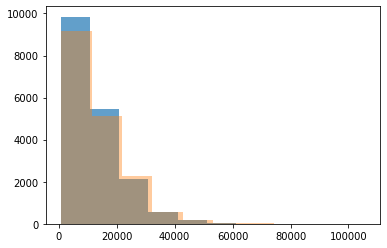

In [120]:
#plt.hist(meta_nuc['umi.counts'][meta_nuc.library_id.isin(['L8TX_181211_01_A02'])])
plt.hist(meta_nuc['umi.counts'][meta_nuc.library_id.isin(['L8TX_181211_01_B02'])],alpha=0.7)
#plt.hist(meta_nuc['umi.counts'][meta_nuc.library_id.isin(['L8TX_181211_01_D02'])],alpha=0.5)
plt.hist(meta_nuc['umi.counts'][meta_nuc.library_id.isin(['L8TX_181211_01_H01'])],alpha=0.4)
#plt.hist(meta_nuc['umi.counts'][meta_nuc.library_id.isin(['L8TX_181211_01_C02'])],alpha=0.5)

In [ ]:
#Get fastqs from https://data.nemoarchive.org/biccn/lab/zeng/transcriptome/sncell/10x_v3/mouse/raw/MOp/
#For B02 and H01
#https://data.nemoarchive.org/biccn/lab/zeng/transcriptome/sncell/10x_v3/mouse/raw/MOp/L8TX_181211_01_B02_S01_L003.fastq.tar
#https://data.nemoarchive.org/biccn/lab/zeng/transcriptome/sncell/10x_v3/mouse/raw/MOp/L8TX_181211_01_H01_S01_L003.fastq.tar


# generate count matrices from allen data 
# allen B02 (nuclear)
! kb count --verbose \
-i /home/ggorin/ref/refdata-gex-mm10-2020-A/kallisto/index.idx \
-g /home/ggorin/ref/refdata-gex-mm10-2020-A/t2g_mm10.txt \
-x 10xv3 \
-o /home/tchari/counts/allen_bivi/B02/ \
-t 30 -m 30G \
-c1 /home/ggorin/ref/refdata-gex-mm10-2020-A/kallisto/cdna_t2c.txt \
-c2 /home/ggorin/ref/refdata-gex-mm10-2020-A/kallisto/intron_t2c.txt \
--workflow lamanno --filter bustools --overwrite --loom \
/home/tchari/counts/allen_bivi/L8TX_181211_01_B02_S01_L003/L8TX_181211_01_B02_S01_L003_R1_001.fastq.gz \
/home/tchari/counts/allen_bivi/L8TX_181211_01_B02_S01_L003/L8TX_181211_01_B02_S01_L003_R2_001.fastq.gz


In [ ]:
#Read in looms from kb

a08 = lp.connect('/home/tchari/counts/allen_bivi/loom/allen_A08_raw.loom')
bars = a08.ca['barcode']
print(bars[0])
genes = a08.ra['gene_name']
U = a08.layers['unspliced'][:,:]
S = a08.layers['spliced'][:,:]
print(S.shape)

In [ ]:
#Filter for cells in annotation

sub_meta = meta_a08[meta_a08.library_id.isin(['L8TX_190430_01_A08'])]


In [ ]:
#OR JUST DO THE TOP 10 CLUSTERS
sublab = []
classlab = []
bars_filt = []
for b in list(sub_meta['Unnamed: 0']):
    ind = a08_members['Unnamed: 0'] == b
    if np.sum(ind) >0:
        lab = list(a08_members['x'][ind])[0]

        ind2 = a08_annots['cluster_id'] == lab
        testlab = list(a08_annots['subclass_label'][ind2])[0]
        if (testlab not in ['Low Quality','doublet','L5 ET','L6 IT Car3','SMC']): #Remove types < 10 cells/low quality
            sublab += list(a08_annots['subclass_label'][ind2])
            classlab += list(a08_annots['class_label'][ind2])

            bars_filt += [b[:b.index('-')]]
    

In [ ]:
#Save loom

### **scMixology Benchmark Datasets**

Need to generate from fastqs, original study only does exon-mapping (S only), 10xv2, Human

In [ ]:
#5 cell line 10x metadata
#metadata from https://github.com/LuyiTian/sc_mixology/blob/master/misc/single_cell_annotations/GSM3618014_10x_5cl_metadata.csv
#https://github.com/LuyiTian/sc_mixology/blob/master/misc/single_cell_annotations/barcode_10x_5cl.csv




In [ ]:
#3 cell line 10x metadata
#Metadata from https://github.com/LuyiTian/sc_mixology/blob/master/misc/single_cell_annotations/GSM3022245_10x_3cl_metadata.csv
#https://github.com/LuyiTian/sc_mixology/blob/master/misc/single_cell_annotations/GSM3022245_index_anno.csv


In [ ]:
#5 cell line mix, GSM3618014
!prefetch SRR8606521 --max-size 30000000000 -O ./ && fasterq-dump --include-technical --split-files SRR8606521

In [ ]:
#3 cell line mix (should concatenate R1s and R2s), GSM3022245


SRR6782109
SRR6782110
SRR6782111
SRR6782112  (10gb enough)




In [ ]:
#5 cell line
kb count --verbose \
-i /home/ggorin/ref/refdata-gex-GRCh38-2020-A/kallisto/index.idx \
-g /home/ggorin/ref/refdata-gex-GRCh38-2020-A/t2g_grch38.txt \
-x 10xv2 \
-o ../counts/norman_crispr/gem1/ \
-t 30 -m 30G \
-c1 /home/ggorin/ref/refdata-gex-GRCh38-2020-A/kallisto/cdna_t2c.txt \
-c2 /home/ggorin/ref/refdata-gex-GRCh38-2020-A/kallisto/intron_t2c.txt \
--workflow lamanno --filter bustools --overwrite --loom \
../counts/norman_crispr/fastq/SRR9602535_1.fastq.gz \
../counts/norman_crispr/fastq/SRR9602535_2.fastq.gz


In [ ]:
#3 cell line

kb count --verbose \
-i /home/ggorin/ref/refdata-gex-GRCh38-2020-A/kallisto/index.idx \
-g /home/ggorin/ref/refdata-gex-GRCh38-2020-A/t2g_grch38.txt \
-x 10xv2 \
-o ../counts/norman_crispr/gem1/ \
-t 30 -m 30G \
-c1 /home/ggorin/ref/refdata-gex-GRCh38-2020-A/kallisto/cdna_t2c.txt \
-c2 /home/ggorin/ref/refdata-gex-GRCh38-2020-A/kallisto/intron_t2c.txt \
--workflow lamanno --filter bustools --overwrite --loom \
../counts/norman_crispr/fastq/SRR9602535_1.fastq.gz \
../counts/norman_crispr/fastq/SRR9602535_2.fastq.gz \
../counts/norman_crispr/fastq/SRR9602536_1.fastq.gz  \
../counts/norman_crispr/fastq/SRR9602536_2.fastq.gz & \


## **Exploratory Datasets**

### **Mouse Breast Cancer Data**

Process from fastqs to get U/S, 10xv2, Genes will be HVGs + 
Breast cancer marker genes

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3045364/ (markers)

In [ ]:
#BRCA1null tumor data https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM4023823



SRR9938469
SRR9938470

In [ ]:
#Metadata https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4023nnn/GSM4023823/suppl/GSM4023823%5FBRCA1%5FB%5Fbarcodes.tsv.gz
#GSM4023823_BRCA1_B_barcodes.tsv


In [ ]:
kb count --verbose \
-i /home/ggorin/ref/refdata-gex-mm10-2020-A/kallisto/index.idx \
-g /home/ggorin/ref/refdata-gex-mm10-2020-A/t2g_mm10.txt \
-x 10xv2 \
-o ../counts/norman_crispr/gem1/ \
-t 30 -m 30G \
-c1 /home/ggorin/ref/refdata-gex-mm10-2020-A/kallisto/cdna_t2c.txt \
-c2 /home/ggorin/ref/refdata-gex-mm10-2020-A/kallisto/intron_t2c.txt \
--workflow lamanno --filter bustools --overwrite --loom \
../counts/norman_crispr/fastq/SRR9602535_1.fastq.gz \
../counts/norman_crispr/fastq/SRR9602535_2.fastq.gz \
../counts/norman_crispr/fastq/SRR9602536_1.fastq.gz  \
../counts/norman_crispr/fastq/SRR9602536_2.fastq.gz & \


In [ ]:
#our own filtering

### **10x 10k PBMC Dataset**

From 10x Genomics, minimal annotations, 10xv3, Human, Genes = literature annotation of PBMC-relevant markers

In [ ]:
#our own filtering

### **Developing Germ Cell Dataset**

Combine two timepoints, 10xv2, Mouse, Genes will be HVGs+ Dev. relevant genes

In [ ]:
#download data, U/S counts
!wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE136nnn/GSE136220/suppl/GSE136220%5Fraw%5Fcounts%5Fmatrix%5Fpgcs%5Fno%5Fadrenal.csv.gz && wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE136nnn/GSE136220/suppl/GSE136220%5Fraw%5Fcounts%5Fmatrix%5Fpgcs%5Fno%5Fadrenal%5Funspliced.csv.gz
        
        

In [ ]:
#Combine germ_allconds_170802_T_E13, germ_allconds_170814_AGPF_E11


In [ ]:
#our own filtering

## **Timing Dataset**

### **Developing Mouse Brain**

La manno/Linnarson data, for testing size/scaling

In [ ]:
#Data from http://mousebrain.org/development/downloads.html (dev_all.loom)

In [ ]:
#no monod fitting here

## **Run Monod on Data to get Technical Param Estimates**

Run on all relevant datasets

In [ ]:
#Define loom and transcriptome for each dataset (Filtered cells beforehand)